I denne notebook findes koden, som blev benyttet i afhandlingens del II om skæbnebegrebet i det moderne gennembrud.

Notebook'en tager udgangspunkt i "Training and Fine-Tuning BERT for Classification: Classifying Goodreads Reviews By Book Genre", en notebook, som projektet – og en i øvrigt meget anbefalelsværdig ressource – [AI for Humanists](https://aiforhumanists.com/tutorials/) på Cornell University har stillet rådighed.

Forud for tekstklassifikationen blev datasættet etableret ved hjælp af biblioteket [spaCy](https://spacy.io/models/da) og den danske NLP-pipeline *da_core_news_md*, hvor sentence segmentation blev benyttet til at finde udtrække ni af modellen identificerede sætninger rundt om nøgleordet: *skæbne*. Følgende regulære udtryk blev benyttet ([a-zæøå]\*)(sk[j]?æbne)([a-zæøå]\*) og ([a-zæøå]\*)(sk[j]?ebne)([a-zæøå]\*), som fanger alle forekomster af ordet ’skæbne’ inklusiv bøjninger, afledninger og sammensætninger. Sidstnævnte betyder, at ord som fx "skæbnesvanger" og "vanskæbne" også indgår i datasættet.

# Installér om importér biblioteker og pakker

In [ ]:
!pip install transformers
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install torch
!pip install datasets
!pip install xformers

In [ ]:
from collections import defaultdict
import random
import pickle
import torch

import os

import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForTokenClassification
from transformers import Trainer, TrainingArguments
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm
from datasets import Dataset

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
sns.set(style='ticks', font_scale=1.2)
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Indlæs data

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

dataset = gc.open('skæbne_datasæt').sheet1
rows = dataset.get_all_values()
df = pd.DataFrame(rows)

df.columns = df.iloc[0]
df = df.iloc[1:]
df

,index,file_name,segment,label
1,299,1896_Lundgaard_DonJuan.txt,"Saa gik Døren op , og den Porcellænsøjede \nvi...",2
2,2153,1882_Winterhjelm_TilStatsraadstaburetten.txt,"Det kan være , at det ikke er hendes Skyld , \...",3
3,16395,1878_SoerensenC_AltForFaedrelandet.txt,“ \n„ Jeg gifter mig aldrig paany . “ \n„ Man ...,1
4,1075,1881_CS_NogleDageAfEnPolitimandsLiv.txt,Tredie Kapitel . \n En stakkels forladt Kone ....,2
5,3786,1871_L.F._Capercapitainen.txt,"Landmanden tilkjendegav ham , at hvis han \nøn...",2
...,...,...,...,...
8088,1132,1888_EwaldHF_Griffenfeld.txt,Saa lod han \nsig ophøie i Adelstanden og anto...,
8089,832,1873_EwaldHF_Agathe.txt,"Deri var nu ingen \nUlykke , uagtet Broderens ...",
8090,5638,1877_EwaldHF_NielsBrahe_2.txt,"For \nat see Eder og Niels Nielsen komme , gik...",
8091,2954,1888_Trafall_KjaempendeMagter.txt,"Der er intet i \nverden , jeg foragter saa som...",


Datasættet deles i to dataframes, dvs. én annoteret og én uannoteret, som eftefølgende får nye indekser.


In [ ]:
split_index = 650
labeled_df = df.iloc[:split_index].reset_index(drop=True)
unlabeled_df = df.iloc[split_index:].reset_index(drop=True)

In [ ]:
labeled_df

,index,file_name,segment,label
0,299,1896_Lundgaard_DonJuan.txt,"Saa gik Døren op , og den Porcellænsøjede \nvi...",2
1,2153,1882_Winterhjelm_TilStatsraadstaburetten.txt,"Det kan være , at det ikke er hendes Skyld , \...",3
2,16395,1878_SoerensenC_AltForFaedrelandet.txt,“ \n„ Jeg gifter mig aldrig paany . “ \n„ Man ...,1
3,1075,1881_CS_NogleDageAfEnPolitimandsLiv.txt,Tredie Kapitel . \n En stakkels forladt Kone ....,2
4,3786,1871_L.F._Capercapitainen.txt,"Landmanden tilkjendegav ham , at hvis han \nøn...",2
...,...,...,...,...
645,4994,1894_Schumacher_AgneteBudde.txt,"Det var pudsigt af iagttage Minerne hos dem , ...",0
646,1745,1870_Anonym_StokhusslavenSoerenVintyvEllerForb...,"Hans Navn er Adolf Skou , og han ør jævnaldren...",1
647,9458,1874_Nordrup_KongValdemarOgTovelille.txt,. Under hendes Vindue stod Du \nmed din Streng...,3
648,750,1882_LieJ_GaaPaa.txt,stod igjen højlig hævet i sin Bevidsthed \nved...,1


In [ ]:
unlabeled_df

,index,file_name,segment,label
0,16492,1883_FT_TugthusfangenHannibalOgDenSmukkeRosali...,"Jeg priser \nSkæbnen , som atter har spillet d...",
1,56,1871_Behrend_Hulda.txt,"Dette Gods tilhører Grev Tadlos , en spansk Ad...",
2,1778,1870_Lange_AaenOgHavet.txt,ligeoverfor hende \nsom overfor Andre . Det va...,
3,1761,1884_Ravnkilde_JudithFurste.txt,"Det er den fornuftigste Handling , \nhan har f...",
4,7599,1877_RygaardHa_PerlefiskerensSoen_1.txt,Dig for af forelske Dig \n i en Kvinde ! . . ....,
...,...,...,...,...
7437,1132,1888_EwaldHF_Griffenfeld.txt,Saa lod han \nsig ophøie i Adelstanden og anto...,
7438,832,1873_EwaldHF_Agathe.txt,"Deri var nu ingen \nUlykke , uagtet Broderens ...",
7439,5638,1877_EwaldHF_NielsBrahe_2.txt,"For \nat see Eder og Niels Nielsen komme , gik...",
7440,2954,1888_Trafall_KjaempendeMagter.txt,"Der er intet i \nverden , jeg foragter saa som...",


Her indlæses romanenernes metadata og tilpasses korpusset.


In [ ]:
metadata = pd.read_excel('/content/drive/MyDrive/Notebooks_and_data/MeMo-corpus-metadata-v1.1-2023-06-20.xlsx')

In [ ]:
metadata_of_interest = ["filename", "firstname", "surname", "pseudonym", "gender", "nationality", "title", "subtitle", "year", "pages", "typeface", "publisher", "price"]

metadata_df = metadata[metadata_of_interest]

metadata_df['filename'] = metadata_df['filename'].str.replace('.pdf', '.txt')

In [ ]:
dir_path = "/content/drive/MyDrive/Notebooks_and_data/romankorpus.v1.0_w_OCR_error_corrections"

txt_files = [file for file in os.listdir(dir_path) if file.endswith(".txt")]

metadata_filenames = metadata_df['filename'].tolist()

missing_files = [filename for filename in metadata_filenames if filename not in txt_files]

metadata_df = metadata_df[~metadata_df['filename'].isin(missing_files)]


In [ ]:
metadata_df['gender'] = metadata_df['gender'].fillna('ukendt')
metadata_df['nationality'] = metadata_df['nationality'].fillna('ukendt')
metadata_df['price'] = metadata_df['price'].fillna('ukendt')
replacement_dict = {'na': 'ukendt', '(se note)': 'ukendt'}
metadata_df['price'] = metadata_df['price'].replace(replacement_dict)

In [ ]:
metadata_df

,filename,firstname,surname,pseudonym,gender,nationality,title,subtitle,year,pages,typeface,publisher,price
0,1870_AndersenHC_LykkePeer.txt,H.C.,Andersen,NaN,m,dk,Lykke-Peer,NaN,1870,183.0,gothic,Reitzel,2.25
2,1870_Brosboell_TranensVarsel.txt,Carl,Brosbøll,Carit Etlar,m,dk,Tranens Varsel,En Roman,1870,528.0,gothic,Chr. Steen & Søn,5.5
3,1870_Dodt_AegteOgUaegte.txt,Beatus,Dodt,NaN,m,dk,Ægte og Uægte,Livsbillede,1870,517.0,gothic,Chr. Steen & Søn,5.35
4,1870_Friis_MoedetPaaLaesoe.txt,J.J.F.,Friis,NaN,m,dk,Mødet paa Læsø,En Fortælling,1870,164.0,gothic,Chr. Steen & Søn,1.85
5,1870_Friis_MagnusHeinesen.txt,J.J.F.,Friis,NaN,m,dk,Magnus Heinesen,En historisk Roman,1870,209.0,gothic,Chr. Steen & Søn,2.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,1899_Tuxen_Hvorfor.txt,Fanny,Tuxen,NaN,f,dk,Hvorfor?,Fortælling,1899,187.0,roman,Hagerup,2.5
909,1879_Anselmo_AmelieEllerLivIDoeden.txt,NaN,NaN,Viktor de Anselmo,NaN,NaN,Amelie eller Liv i Døden,Efter en afdød Jordemoders Meddelelser. Roman,1879,480.0,gothic,Lohmannske Forlagsforretning,3
911,1899_Wied_LivsensOndskab.txt,Gustav,Wied,NaN,m,dk,Livsens Ondskab,Billeder fra Gammelkøbing,1899,390.0,roman,Gyldendal,5.5
912,1899_WintherH_PaaFremmedGrund.txt,Hedevig,Winther,NaN,f,dk,Paa fremmed Grund,Fortælling,1899,180.0,roman,Jens Møller,2.25


# Finjustering af model

## Klargøring af data

Her splittes den annoterede dataframe i et træningssæt og et testsæt til finjusteringen af modellen. 80% af segmenterne bruges til træning, mens 20% bruges til test.
Da datasættet ikke er balanceret, anvendes et stratificeret split, der tager højde for den ujævne distribution af kategorier.
Jeg har brugt `random_state` parameteret til at sikre et reproducerbart split, som tilgodeser de kategorier, jeg er særligt interesseret i, nemlig førmoderne og moderne skæbneopfattelser.

In [ ]:
X = labeled_df['segment']
y = labeled_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, stratify=y, random_state=6)
train_data = pd.DataFrame({'label': y_train, 'segment': X_train})
test_data = pd.DataFrame({'label': y_test, 'segment': X_test})

Her benyttes en dictionary til at forbinde hver annotationsværdi med en liste af segmenter, som har den pågældende annotationsværdi. Efterføglende oversættes annotationerne fra numeriske værdier til tekst-etiketter. Resultatet er en ny dictionary med de opdaterede annotationsværdier.



In [ ]:
train_label_dict = train_data.groupby('label')['segment'].apply(list).to_dict()
train_label_dict.keys()

dict_keys(['0', '1', '2', '3'])

In [ ]:
label_mapping = {
    '0': 'Førmoderne',
    '1': 'Moderne',
    '2': 'Klichéer',
    '3': 'Tvivlstilfælde'}

train_label_segments_dict = {
    label_mapping.get(key, key): value for key, value in train_label_dict.items()
}
train_label_segments_dict.keys()

dict_keys(['Førmoderne', 'Moderne', 'Klichéer', 'Tvivlstilfælde'])

I de følgende kodelinjer klargøres dataen til tokenisering. Segmenterne og deres tilknyttede labels organiseres i lister, som kan anvendes som input til modellen.

In [ ]:
_segments = []

for key, values in train_label_segments_dict.items():
    for value in values:
        _segments.append([key, value])

for _label, _segments in train_label_segments_dict.items():
  print(_label, _segments)

Førmoderne ['Denne nikkede svagt . \n„ Vil I give mig dette Sværd ? “ udbrød Kongen forbavset . \n Denne Gang nikkede den Gamle ivrigere , og gjorde Tegn til Kongen , af han skulde bøie sit Øre ned til hans Blnnd . \n I den Tro , af den Gamle vilde give ham Underretning om Barnets Skjæbne , lagde Kongen sig paa Knæ ved hans Side og lyttede til hans Ord : \n„ Stjernerne havde sagt mig , “ hviskede den Gamle næppe hørligt , „ af I vilde komme til mig , før jeg blev revet herfra . Det Sværd skulde da skjænkes Eder . Det er smeddet til Norges gamle Konger , og . \n\n', 'da Grevinde de Olozaga indaandede Blomsterduften , hævede hun Hovedet og kastede et Blik ud paa Balkonen . \n Hendes Blik mødte et deiligt stort Rosenfræ , der prangede med store , nys udsprungne Roser . \n Det var fra dem Vellugten hidrørte . \n Ved Synet af dem førte Grevinde de Olozaga hurtigt sin Haand op til sin hvide Pande , som for at fastholde en Tanke , der pludselig var opstaaet indenfor den . \n\n Denne Tanke — v

In [ ]:
train_texts = []
train_labels = []

for _label, _segments in train_label_segments_dict.items():

  for _segment in _segments:
    train_texts.append(_segment)
    train_labels.append(_label)

len(train_texts), len(train_labels)

(520, 520)

In [ ]:
train_labels[0], train_texts[0]

('Førmoderne',
 'Denne nikkede svagt . \n„ Vil I give mig dette Sværd ? “ udbrød Kongen forbavset . \n Denne Gang nikkede den Gamle ivrigere , og gjorde Tegn til Kongen , af han skulde bøie sit Øre ned til hans Blnnd . \n I den Tro , af den Gamle vilde give ham Underretning om Barnets Skjæbne , lagde Kongen sig paa Knæ ved hans Side og lyttede til hans Ord : \n„ Stjernerne havde sagt mig , “ hviskede den Gamle næppe hørligt , „ af I vilde komme til mig , før jeg blev revet herfra . Det Sværd skulde da skjænkes Eder . Det er smeddet til Norges gamle Konger , og . \n\n')

<Axes: >

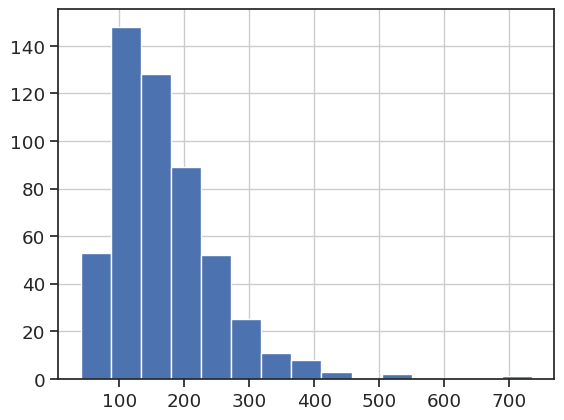

In [ ]:
# Her ses længden af træningssegmenterne. Antal tokens ses på x-aksen og antallet af forekomster på y-aksen.

seq_len = [len(i.split()) for i in train_texts]

pd.Series(seq_len).hist(bins = 15)

I de følgende linjer anvendes samme procedure på testsættet.

In [ ]:
test_label_dict = test_data.groupby('label')['segment'].apply(list).to_dict()
test_label_dict.keys()

dict_keys(['0', '1', '2', '3'])

In [ ]:
label_mapping = {
    '0': 'Førmoderne',
    '1': 'Moderne',
    '2': 'Klichéer',
    '3': 'Tvivlstilfælde'}

test_label_segments_dict = {
    label_mapping.get(key, key): value for key, value in test_label_dict.items()
}
test_label_segments_dict.keys()

dict_keys(['Førmoderne', 'Moderne', 'Klichéer', 'Tvivlstilfælde'])

In [ ]:
test_texts = []
test_labels = []

for _label, _segments in test_label_segments_dict.items():
    for _segment in _segments:
        test_texts.append(_segment)
        test_labels.append(_label)

len(test_texts), len(test_labels)

(130, 130)

In [ ]:
test_labels[0], test_texts[0]

('Førmoderne',
 'Det er Guds Straf , “ mumlede han forfærdet . „ Det anede mig nok , at det maatte ende saaledes . “ \n„ Ja , I har Ret . Der synes næsten at ligge et Skjæbnens Fingerpeg i dette . “ \n„ Polichinel har altsaa opholdt sig i det tavse Palads siden den Dag , han forsvandt her fra Byen ? “ \n„ Hvor længe er det siden ?')

<Axes: >

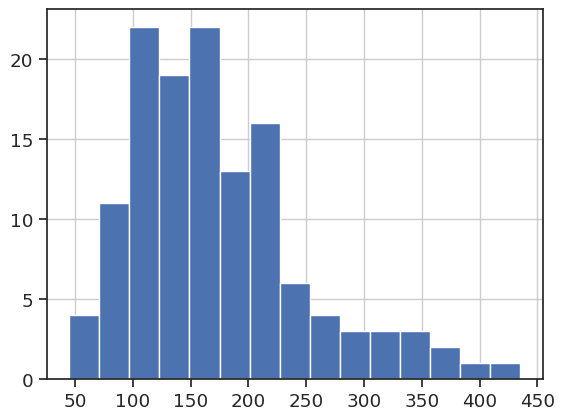

In [ ]:
seq_len = [len(i.split()) for i in test_texts]

pd.Series(seq_len).hist(bins = 15)

Her tilknyttes ID'er til etiketterne, som skal bruges til tokeniseringen af segmenterne.

In [ ]:
label2id = {label: id for id, label in enumerate(dict.fromkeys(train_labels))}
id2label = {id: label for label, id in label2id.items()}

In [ ]:
label2id.keys()

dict_keys(['Førmoderne', 'Moderne', 'Klichéer', 'Tvivlstilfælde'])

In [ ]:
id2label.keys()

dict_keys([0, 1, 2, 3])

## Indlæs modellen


Her indlæses modellen MeMo-BERT-03 via Huggingface, der er tilpasset MeMo-korpusset og 1800-tals-dansk. Se https://huggingface.co/MiMe-MeMo


In [ ]:
model_name = "MiMe-MeMo/MeMo-BERT-03"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(id2label))


Maks. længde på input til modellen defineres (ud fra antal tokens), hvorefter trænings- og testssættet tokeniseres.

In [ ]:
max_length = 512

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

train_labels_encoded = [label2id[y] for y in train_labels]
test_labels_encoded  = [label2id[y] for y in test_labels]

In [ ]:
' '.join(train_encodings[0].tokens[0:100])

'<s> ▁Denne ▁nikkede ▁svagt ▁. ▁„ ▁Vil ▁I ▁give ▁mig ▁dette ▁Sværd ▁? ▁“ ▁udbrød ▁Kongen ▁forbavset ▁. ▁Denne ▁Gang ▁nikkede ▁den ▁Gamle ▁ivrig ere ▁, ▁og ▁gjorde ▁Tegn ▁til ▁Kongen ▁, ▁af ▁han ▁skulde ▁bø ie ▁sit ▁Øre ▁ned ▁til ▁hans ▁Bl n nd ▁. ▁I ▁den ▁Tro ▁, ▁af ▁den ▁Gamle ▁vilde ▁give ▁ham ▁Under retning ▁om ▁Barnets ▁Skj æbne ▁, ▁lagde ▁Kongen ▁sig ▁paa ▁Knæ ▁ved ▁hans ▁Side ▁og ▁lyttede ▁til ▁hans ▁Ord ▁: ▁„ ▁St jernerne ▁havde ▁sagt ▁mig ▁, ▁“ ▁hviskede ▁den ▁Gamle ▁næppe ▁hør ligt ▁, ▁„ ▁af ▁I ▁vilde ▁komme ▁til ▁mig ▁,'

In [ ]:
' '.join(test_encodings[0].tokens[0:100])

'<s> ▁Det ▁er ▁Guds ▁Straf ▁, ▁“ ▁mumlede ▁han ▁forfærdet ▁. ▁„ ▁Det ▁anede ▁mig ▁nok ▁, ▁at ▁det ▁maatte ▁ende ▁saaledes ▁. ▁“ ▁„ ▁Ja ▁, ▁I ▁har ▁Ret ▁. ▁Der ▁synes ▁næsten ▁at ▁ligge ▁et ▁Skj æb nens ▁Finger peg ▁i ▁dette ▁. ▁“ ▁„ ▁Pol ich in el ▁har ▁altsaa ▁opholdt ▁sig ▁i ▁det ▁tavse ▁Palads ▁siden ▁den ▁Dag ▁, ▁han ▁forsvandt ▁her ▁fra ▁Byen ▁? ▁“ ▁„ ▁Hvor ▁længe ▁er ▁det ▁siden ▁? </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'

In [ ]:
set(train_labels_encoded)

{0, 1, 2, 3}

In [ ]:
set(test_labels_encoded)

{0, 1, 2, 3}

I de næste linjer kombineres de kodede etiketter og tekster til datasæt-objekter via torch-pakken.

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = MyDataset(train_encodings, train_labels_encoded)
test_dataset = MyDataset(test_encodings, test_labels_encoded)

In [ ]:
' '.join(train_dataset.encodings[0].tokens[0:100])

'<s> ▁Denne ▁nikkede ▁svagt ▁. ▁„ ▁Vil ▁I ▁give ▁mig ▁dette ▁Sværd ▁? ▁“ ▁udbrød ▁Kongen ▁forbavset ▁. ▁Denne ▁Gang ▁nikkede ▁den ▁Gamle ▁ivrig ere ▁, ▁og ▁gjorde ▁Tegn ▁til ▁Kongen ▁, ▁af ▁han ▁skulde ▁bø ie ▁sit ▁Øre ▁ned ▁til ▁hans ▁Bl n nd ▁. ▁I ▁den ▁Tro ▁, ▁af ▁den ▁Gamle ▁vilde ▁give ▁ham ▁Under retning ▁om ▁Barnets ▁Skj æbne ▁, ▁lagde ▁Kongen ▁sig ▁paa ▁Knæ ▁ved ▁hans ▁Side ▁og ▁lyttede ▁til ▁hans ▁Ord ▁: ▁„ ▁St jernerne ▁havde ▁sagt ▁mig ▁, ▁“ ▁hviskede ▁den ▁Gamle ▁næppe ▁hør ligt ▁, ▁„ ▁af ▁I ▁vilde ▁komme ▁til ▁mig ▁,'

In [ ]:
' '.join(test_dataset.encodings[0].tokens[0:100])

'<s> ▁Det ▁er ▁Guds ▁Straf ▁, ▁“ ▁mumlede ▁han ▁forfærdet ▁. ▁„ ▁Det ▁anede ▁mig ▁nok ▁, ▁at ▁det ▁maatte ▁ende ▁saaledes ▁. ▁“ ▁„ ▁Ja ▁, ▁I ▁har ▁Ret ▁. ▁Der ▁synes ▁næsten ▁at ▁ligge ▁et ▁Skj æb nens ▁Finger peg ▁i ▁dette ▁. ▁“ ▁„ ▁Pol ich in el ▁har ▁altsaa ▁opholdt ▁sig ▁i ▁det ▁tavse ▁Palads ▁siden ▁den ▁Dag ▁, ▁han ▁forsvandt ▁her ▁fra ▁Byen ▁? ▁“ ▁„ ▁Hvor ▁længe ▁er ▁det ▁siden ▁? </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'

**Finjustering af BERT-modellen**

Først defineres træningsparametrene, hvor antallet af epoker, batch-størrelse, learning rate og opvarmningstrin er justeret manuelt efter løbende inspektion af resultaterne. Efterfølgende defineres en evalueringsfunktion og modellen finjusteres.


In [ ]:
training_args = TrainingArguments(
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=6,
    learning_rate=3e-5,
    warmup_steps=100,
    weight_decay=1e-5,
    output_dir='./results',
    logging_dir='./logs',
    logging_steps=50,
    evaluation_strategy='steps',
    optim="adamw_torch"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
50,1.336400,1.277319,0.423077
100,1.305400,1.246491,0.423077
150,1.297500,1.257044,0.423077
200,1.250200,1.130012,0.484615
250,1.174800,1.100199,0.500000
300,1.010100,1.036783,0.546154
350,0.867300,0.984453,0.584615


TrainOutput(global_step=390, training_loss=1.154088876186273, metrics={'train_runtime': 186.6126, 'train_samples_per_second': 8.36, 'train_steps_per_second': 2.09, 'total_flos': 410460616949760.0, 'train_loss': 1.154088876186273, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.9795740842819214,
 'eval_accuracy': 0.5923076923076923,
 'eval_runtime': 4.1352,
 'eval_samples_per_second': 31.437,
 'eval_steps_per_second': 5.32,
 'epoch': 3.0}

In [ ]:
predicted_results = trainer.predict(test_dataset)

In [ ]:
predicted_results.predictions.shape

(130, 4)

In [ ]:
predicted_labels = predicted_results.predictions.argmax(-1)
predicted_labels = predicted_labels.flatten().tolist()
predicted_labels = [id2label[l] for l in predicted_labels]

In [ ]:
len(predicted_labels)

130

Resultatet af finjusteringen inspiceres ved hjælp af en klassifikationsrapport, der viser præcision, genkaldelse, F1-score og antal for hver kategori.

In [ ]:
print(classification_report(test_labels,
                            predicted_labels))

                precision    recall  f1-score   support

    Førmoderne       0.71      0.55      0.62        22
      Klichéer       0.62      0.73      0.67        55
       Moderne       0.60      0.35      0.44        17
Tvivlstilfælde       0.49      0.53      0.51        36

      accuracy                           0.59       130
     macro avg       0.60      0.54      0.56       130
  weighted avg       0.60      0.59      0.59       130



Og en confusion matrix, der viser hvilke kategorier, modellen forveksler.

In [ ]:
print(confusion_matrix(test_labels,
                            predicted_labels))

[[12  5  1  4]
 [ 2 40  2 11]
 [ 0  6  6  5]
 [ 3 13  1 19]]


Inspektion af størrelsesforholdet mellem test-prædiktationer og trænings-annotationer.

(array([17.,  0.,  0., 39.,  0.,  0., 64.,  0.,  0., 10.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

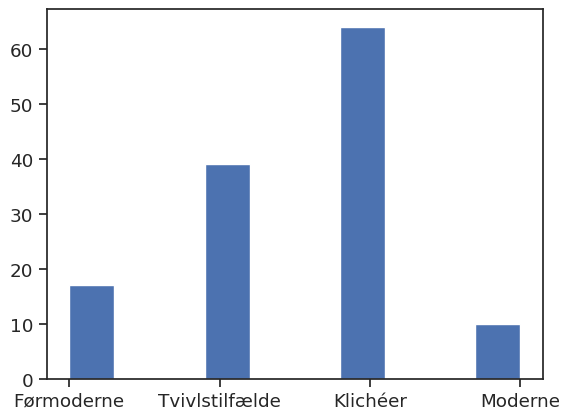

In [ ]:
plt.hist(predicted_labels)

(array([ 87.,   0.,   0.,  70.,   0.,   0., 220.,   0.,   0., 143.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

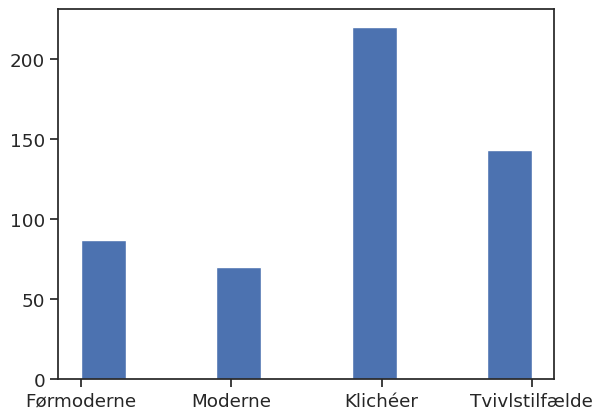

In [ ]:
plt.hist(train_labels)

In [ ]:
# Modellen gemmes
#output_dir = '/content/drive/MyDrive/Notebooks_and_data/Skæbne_WSD_model'
#trainer.save_model(output_dir)

# Prædiktion

Her bruges den finjusterede model til at prædiktere resten af segmenterne i datasættet. Først tokeniseres inputtet, hvorefter modellen appliceres via Hugging Faces pipeline til tekstklassifikation. Resultaterne opsamles i lister med filnavne, segmenter, etiketter og score, og disse data konverteres til en pandas dataframe, som efterfølgende gemmes som excel-fil.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("MiMe-MeMo/MeMo-BERT-03")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
finetuned_model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/Notebooks_and_data/Skæbne_WSD_model')

pipe = pipeline("text-classification", tokenizer=tokenizer, model=finetuned_model, framework="pt")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
dataset = Dataset.from_pandas(unlabeled_df)

In [ ]:
predictions = tqdm(pipe(KeyDataset(dataset, "segment"), truncation="only_first"))

  0%|          | 0/7442 [00:00<?, ?it/s]

In [ ]:
file_names = []
segments = []
labels = []
scores = []

for idx, label_prediction in enumerate(predictions):
    file_name = dataset[idx]["file_name"]
    segment = dataset[idx]["segment"]
    label = label_prediction["label"]
    score = label_prediction["score"]

    file_names.append(file_name)
    segments.append(segment)
    labels.append(label)
    scores.append(score)

data = {"filename": file_names, "segment": segments,"predicted label": labels,"confidence score": scores}

predictions_df = pd.DataFrame(data)

In [ ]:
# Prædiktionerne gemmes
# predictions_df.to_excel('/content/drive/MyDrive/Notebooks_and_data/predictions_df.xlsx', index=False)

# Analyse

Her indlæses prædiktionerne, hvorefter de tilkobles udvalgt metadata og slås sammen med annotationerne.

In [ ]:
predictions_df = pd.read_excel('/content/drive/MyDrive/Notebooks_and_data/predictions_df.xlsx')

In [ ]:
predictions_df_copy = predictions_df
predictions_df_copy.rename(columns={'predicted label': 'label'}, inplace=True)
predictions_df_w_metadata = predictions_df_copy.merge(metadata_df, how="left", on="filename")

labeled_df_copy = labeled_df
labeled_df_copy.rename(columns={'file_name': 'filename'}, inplace=True)

annotations_df_w_metadata = labeled_df_copy.merge(metadata_df, how="left", on="filename")

full_dataset_df = pd.concat([labeled_df_copy, predictions_df_copy], axis=0)

full_dataset_df_w_metadata = full_dataset_df.merge(metadata_df, how="left", on="filename")

In [ ]:
# Værdiernes navne ændres igen.

value_mapping = {
    '0': 'Førmoderne',
    '1': 'Moderne',
    '2': 'Kliché',
    '3': 'Tvivlstilfælde',
    'LABEL_0': 'Førmoderne',
    'LABEL_1': 'Moderne',
    'LABEL_2': 'Kliché',
    'LABEL_3': 'Tvivlstilfælde'
}

full_dataset_df_w_metadata['label'] = full_dataset_df_w_metadata['label'].replace(value_mapping)
full_dataset_df_w_metadata

In [ ]:
# Det samlede datasæt gemmes
# full_dataset_df_w_metadata.to_excel('/content/drive/MyDrive/Notebooks_and_data/skæbne_datasæt.xlsx', index=False)

Inspektion af forekomster af de enkelte kategorier i datasættet.

In [ ]:
value_counts = full_dataset_df_w_metadata['label'].value_counts()
print(value_counts)

label
Kliché            4062
Tvivlstilfælde    2545
Førmoderne         858
Moderne            627
Name: count, dtype: int64


Antal etiketter tælles for hver roman i datasættet, og kategoriernes fordeling i de enkelte romaner beregnes i procent. Derefter kombineres både de absolutte tal og procentfordelingen for en samlet oversigt.

In [ ]:
filename_label_counts = full_dataset_df_w_metadata.groupby(['filename', 'label']).size().unstack(fill_value=0)

filename_label_counts['I alt'] = filename_label_counts.sum(axis=1)

filename_label_percentages = filename_label_counts.div(filename_label_counts['I alt'], axis=0) * 100

combined_df = filename_label_counts.copy()

for col in filename_label_counts.columns:
    combined_df[col + '_percent'] = filename_label_percentages[col]

combined_df = combined_df.sort_values(by='I alt', ascending=False)

combined_df = combined_df.reset_index()

combined_df

label,filename,Førmoderne,Kliché,Moderne,Tvivlstilfælde,I alt,Førmoderne_percent,Kliché_percent,Moderne_percent,Tvivlstilfælde_percent,I alt_percent
0,1898_RygaardHo_Kongesvaerdet.txt,56,77,2,33,168,33.333333,45.833333,1.190476,19.642857,100.0
1,1875_SoerensenC_SkjaebnensVeie.txt,19,54,4,39,116,16.379310,46.551724,3.448276,33.620690,100.0
2,1874_SoerensenC_KongensYndling.txt,14,68,0,19,101,13.861386,67.326733,0.000000,18.811881,100.0
3,1880_Andersen_DenGodeAlvilda.txt,2,84,1,6,93,2.150538,90.322581,1.075269,6.451613,100.0
4,1878_SoerensenC_AltForFaedrelandet.txt,8,55,1,22,86,9.302326,63.953488,1.162791,25.581395,100.0
...,...,...,...,...,...,...,...,...,...,...,...
777,1889_Vandel_Kraemmerliv.txt,0,0,0,1,1,0.000000,0.000000,0.000000,100.000000,100.0
778,1870_Gerson_AfDetDagligeLiv.txt,0,1,0,0,1,0.000000,100.000000,0.000000,0.000000,100.0
779,1875_EwaldHF_KnudGyldenstjerne_2.txt,0,0,0,1,1,0.000000,0.000000,0.000000,100.000000,100.0
780,1881_Roed_HvadGunnarHoerte.txt,0,1,0,0,1,0.000000,100.000000,0.000000,0.000000,100.0


Her gøres det samme for forfatterskaber i stedet for romaner, men først oprettes en ny kollonne til forfatternavn, og hvis et forfatternavn ikke er identificeret bruges et evt. pseudonym.

In [ ]:
full_dataset_df_w_metadata['author_name'] = (full_dataset_df_w_metadata['firstname'].str.strip() + ' ' + full_dataset_df_w_metadata['surname'].str.strip()).str.replace(r'\s+', ' ', regex=True)
full_dataset_df_w_metadata['author_name'].fillna(full_dataset_df_w_metadata['pseudonym'], inplace=True)

In [ ]:
filename_label_counts = full_dataset_df_w_metadata.groupby(['author_name', 'label']).size().unstack(fill_value=0)

filename_label_counts['I alt'] = filename_label_counts.sum(axis=1)

filename_label_percentages = filename_label_counts.div(filename_label_counts['I alt'], axis=0) * 100

combined_df = filename_label_counts.copy()

for col in filename_label_counts.columns:
    combined_df[col + '_percent'] = filename_label_percentages[col]

combined_df = combined_df.sort_values(by='I alt', ascending=False)

combined_df = combined_df.reset_index()

combined_df

label,author_name,Førmoderne,Kliché,Moderne,Tvivlstilfælde,I alt,Førmoderne_percent,Kliché_percent,Moderne_percent,Tvivlstilfælde_percent,I alt_percent
0,Carl Sørensen,53,325,17,133,528,10.037879,61.553030,3.219697,25.189394,100.0
1,Robert Hjelm,21,130,12,116,279,7.526882,46.594982,4.301075,41.577061,100.0
2,James Vendé,38,111,4,74,227,16.740088,48.898678,1.762115,32.599119,100.0
3,H.F. Ewald,17,132,6,45,200,8.500000,66.000000,3.000000,22.500000,100.0
4,Claudius Albertius,34,88,1,71,194,17.525773,45.360825,0.515464,36.597938,100.0
...,...,...,...,...,...,...,...,...,...,...,...
327,Jens Andreas Friis,0,0,1,0,1,0.000000,0.000000,100.000000,0.000000,100.0
328,Peder Thisted,0,0,1,0,1,0.000000,0.000000,100.000000,0.000000,100.0
329,S. Christensen Stæhr,0,0,0,1,1,0.000000,0.000000,0.000000,100.000000,100.0
330,Peter Alsted,0,1,0,0,1,0.000000,100.000000,0.000000,0.000000,100.0


Her tælles antallet af kategorier inden for de enkelte år.


In [ ]:
df_grouped = full_dataset_df_w_metadata.groupby(['year', 'label']).size().unstack(fill_value=0)

df_grouped['I alt'] = df_grouped.sum(axis=1)

df_grouped = df_grouped.reset_index()

df_grouped['year'] = df_grouped['year'].astype(int)

df_grouped.columns.name = None

df_grouped

,year,Førmoderne,Kliché,Moderne,Tvivlstilfælde,I alt
0,1870,24,103,5,70,202
1,1871,20,151,9,67,247
2,1872,8,81,2,25,116
3,1873,15,143,10,61,229
4,1874,85,214,8,117,424
5,1875,77,327,42,204,650
6,1876,68,241,21,192,522
7,1877,40,216,19,113,388
8,1878,31,174,20,104,329
9,1879,50,214,14,126,404


Og kategorierne visualiseres med et linjediagram, der viser fordelingen af skæbnekategorier gennem perioden i absolutte frekvenser.

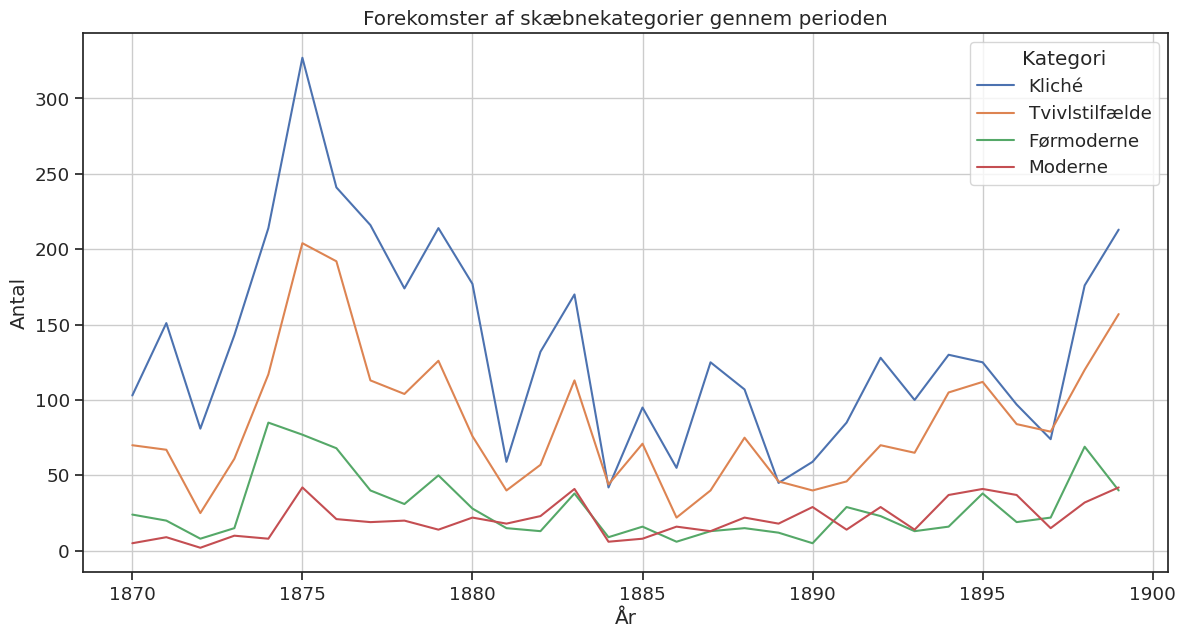

In [ ]:
max_values = df_grouped.iloc[:, 1:-1].max()

sorted_labels = max_values.sort_values(ascending=False).index

plt.figure(figsize=(14, 7))

for label in sorted_labels:
    plt.plot(df_grouped['year'], df_grouped[label], label=f'{label}')

plt.title('Forekomster af skæbnekategorier gennem perioden')
plt.xlabel('År')
plt.ylabel('Antal')

plt.legend(title='Kategori')
plt.grid(True)
plt.show()

Her isoleres kategorierne 'førmoderne' og 'moderne' skæbneopfattelser, og deres fordeling over tid visualiseres igen med et linjediagram.

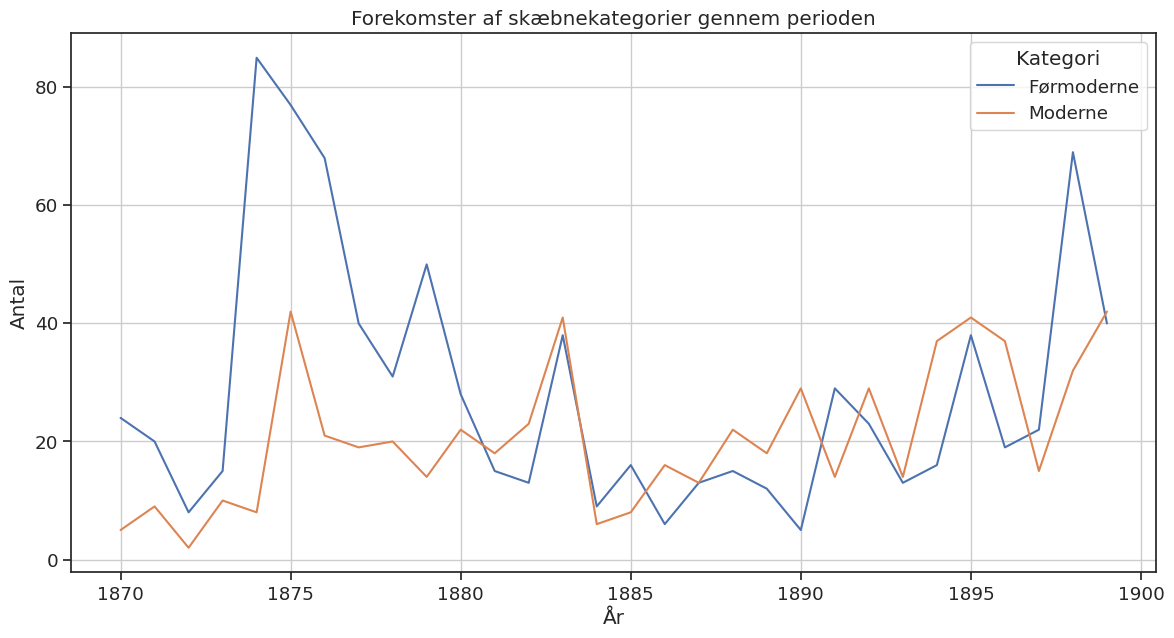

In [ ]:
df_filtered = full_dataset_df_w_metadata[full_dataset_df_w_metadata['label'].isin(['Moderne', 'Førmoderne'])]

df_grouped = df_filtered.groupby(['year', 'label']).size().unstack(fill_value=0)

df_grouped = df_grouped.reset_index()

df_grouped['year'] = df_grouped['year'].astype(int)

df_grouped.columns.name = None

max_values = df_grouped.iloc[:, 1:].max()

sorted_labels = max_values.sort_values(ascending=False).index

plt.figure(figsize=(14, 7))

for label in sorted_labels:
    plt.plot(df_grouped['year'], df_grouped[label], label=label)

plt.title('Forekomster af skæbnekategorier gennem perioden')
plt.xlabel('År')
plt.ylabel('Antal')

plt.legend(title='Kategori')
plt.grid(True)
plt.show()